In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
%matplotlib inline

In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.predict(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [5]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test_fin = test_data['data']

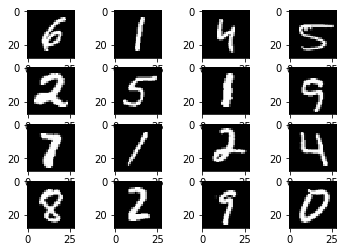

In [6]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

## Подготовка датасета

### Деление на обучающие, тестовые и валидационные подвыборки

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train_oh, test_size=0.2, 
                                                    random_state=12, stratify=Y_train)

In [8]:
len(y_train)

42000

In [9]:
len(y_test)

10500

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                                    random_state=12)

In [11]:
len(y_train)

33600

In [12]:
len(y_val)

8400

### Непосредственное преобразование данных

In [13]:
mu = np.mean(X_train)
std = np.std(X_train)
eps = 1e-5

In [14]:
X_train = (X_train - mu) / (std + eps)
X_val = (X_val - mu) / (std + eps)
X_test = (X_test - mu) / (std + eps)

In [15]:
X_test_fin = (X_test_fin - mu) / (std + eps)

In [16]:
A = np.array([[1, 2], [3, 4]])

In [17]:
np.sum(A, axis=1)

array([3, 7])

## Определение слоев сети

In [18]:
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        cache = exps
        return (exps / np.sum(exps, axis=1).reshape(-1, 1)), cache 
    
    def backward(self, din, cache):
        exps = cache
        sums = np.sum(exps, axis=1)
        isums = 1 / sums
        dhat1 = din * isums.reshape(-1, 1)
        
        dhat2 = din * exps
        dhat2 = dhat2 * (- isums * isums).reshape(-1, 1)
        dhat2 = dhat2 * exps
        
        dexp = dhat1 + dhat2
        
        dout = dexp * exps
        return dout

In [19]:
class CrossEntropy:
    
    def forward(self, y, scores):
        sm = Softmax()
        self.sm = sm
        
        loss = 0
        probs, cache_sm = sm.forward(scores)
        logs = - np.log(probs) * y
        loss = np.sum(logs) / len(y)
        
        cache = (y, scores, probs, logs, cache_sm)
        
        return loss, cache
        
    
    def backward(self, din, cache):
        y, scores, probs, logs, exps = cache
        N = len(y)
        
        dsum = - din * (1 / N) * y * np.ones_like(probs)
        dlog = dsum / probs
        dout = self.sm.backward(dlog, exps)
        return dout

In [71]:
class MultiLayerNetwork:
    
    def __init__(self, in_size, hidden_sizes, num_classes, reg=0.0, learning_rate=1e-5):
        sizes = np.hstack((np.array(in_size), hidden_sizes, np.array(num_classes)))
        self.W = []
        self.b = []
        
        for i in range(len(sizes) - 1):
            in_size = sizes[i]
            out_size = sizes[i+1]
            self.W.append(np.random.normal(scale=1, size=[in_size, out_size]) * np.sqrt(2 / in_size))
            self.b.append(np.zeros(out_size))
        
        self.reg = reg
        self.lr = learning_rate
    
    def affine_forward(self, x, num):
        W = self.W[num]
        b = self.b[num]
        out = np.dot(x, W) + b
        cache = (x, num)
        return out, cache
    
    def relu_forward(self, x):
        return np.maximum(0, x)
    
    def affine_relu_forward(self, x, num):
        y, affine_cache = self.affine_forward(x, num)
        out = self.relu_forward(y)
        relu_cache = out
        return out, (affine_cache, relu_cache)
    
    
    def affine_backward(self, dout, cache):
        x, num = cache
        W = self.W[num]
        b = self.b[num]
        num_exam = x.shape[0]
        
        dw = np.dot(x.reshape(num_exam, -1).T, dout)
        dx = np.dot(dout, W.T).reshape(x.shape)
        db = np.dot(np.ones(num_exam), dout).T
        
        return dx, dw, db
        
    def relu_backward(self, dout, cache):
        mask = cache
        mask = mask <= 0
        or_shape = dout.shape
        dx = copy.deepcopy(dout)
        dx = dout.flatten()
        mask = mask.flatten()
        dx[mask] = 0
        dx = dx.reshape(or_shape)
        
        return dx

    def affine_relu_backward(self, dout, cache):
        affine_cache, relu_cache = cache
        dout = self.relu_backward(dout, relu_cache)
        dx, dw, db = self.affine_backward(dout, affine_cache)
        return dx, dw, db
    
    def predict(self, x):
        h = copy.deepcopy(x)
        for num in range(len(self.W) - 1):
            h, _ = self.affine_relu_forward(h, num)
        num += 1
        scores, _ = self.affine_forward(h, num)
        return scores
    
    def forward_pass(self, x, y):
        cache = []
        masks = []
        batch = x
        for num in range(len(self.W) - 1):
            batch, cur_cache = self.affine_relu_forward(batch, num)
            batch, cur_mask = self.forward_dropout(batch)
            cache.append(cur_cache)
            masks.append(cur_mask)
        num += 1
        scores, cur_cache = self.affine_forward(batch, num)
        cache.append(cur_cache)
        return scores, cache, masks
    
    def forward_dropout(self, x):
        p = self.p
        mask = (np.random.rand(*x.shape) < p) / p
        out = x * mask
        return out, mask
        
    def backward_dropout(self, din, mask):
        return din * mask
    
    def forward_loss(self, scores, y, loss_f):
        sum_ww = 0
        num = 0
        reg = self.reg
        for num in range(len(self.W)):
            w = self.W[num]
            sum_ww += np.sum(w * w)
        loss, loss_cache = loss_f.forward(y, scores)
        loss += 0.5 * reg * sum_ww
        return loss, loss_cache
     
    def train(self, x, y, X_val, y_val, epoches=1, batch_size=1, p=1):
        reg = self.reg
        lr = self.lr
        self.p = p
        iter_per_epoche = x.shape[0] // batch_size
        tr_losses = []
        te_losses = []
        for epoche in range(epoches):
            for i in range(iter_per_epoche):
                idx = np.random.randint(low=0, high=x.shape[0], size=batch_size)
                batch = x[idx]
                batch_y = y[idx]
                
                #forward pass
                scores, cache, masks= self.forward_pass(batch, batch_y)
                loss_f = CrossEntropy()
                loss, loss_cache = self.forward_loss(scores, batch_y, loss_f)
                
                #backward pass
                dout = 1
                dout = loss_f.backward(dout, loss_cache)
                dout, dw, db = self.affine_backward(dout, cache[-1])
                self.W[-1] -= (lr * dw + reg * self.W[-1])
                self.b[-1] -= lr * db
                for i in range(len(cache)-2, -1, -1):
                    dout = self.backward_dropout(dout, masks[i])
                    dout, dw, db = self.affine_relu_backward(dout, cache[i])
                    self.W[i] -= (lr * dw + reg * self.W[i])
                    self.b[i] -= lr * db
            
            
            scores = self.predict(x)
            loss, loss_cache = loss_f.forward(y, scores)
            acc = compute_acc(x[0:10000], y[0:10000], self)
            tr_losses.append((loss, acc))
            
            scores = self.predict(X_val)
            loss, loss_cache = loss_f.forward(y_val, scores)
            acc = compute_acc(X_val[0:1000], y_val[0:1000], self)
            te_losses.append((loss, acc))
                
            if(epoche % 10 == 0):
                print("epoche:", epoche)
                scores = self.predict(x)
                loss, loss_cache = self.forward_loss(scores, y, loss_f)
                print(loss)
                
        return (tr_losses, te_losses)
                

In [72]:
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.predict(X_test[i])
        y = np.argmax(y_h)
        idx = np.argmax(Y_test[i])
        if(y == idx):
            acc += 1.0
    return acc / Y_test.shape[0]

In [73]:
X_train.shape[0]

33600

## Опеределение самой сети

In [108]:
"""learning_rate = [2e-4]
losses = []
for lr in learning_rate:"""
lr = 1e-5
net = MultiLayerNetwork(X_train.shape[1], 100, 10, learning_rate=lr, reg=0)
losses = net.train(X_train[0:10], y_train[0:10], X_val, y_val, batch_size = 1, epoches=600, p=1)
#losses.append(cur_losses)

epoche: 0
3.292045408221199
epoche: 10
3.2155252836262322
epoche: 20
3.1426127953150464
epoche: 30
3.072640546398094
epoche: 40
3.006876473919874
epoche: 50
2.9340540349488373
epoche: 60
2.872009788642628
epoche: 70
2.8137939274434256
epoche: 80
2.7528413367027396
epoche: 90
2.6929845060390756
epoche: 100
2.632204910922037
epoche: 110
2.57509509085314
epoche: 120
2.524437159057649
epoche: 130
2.469964456756738
epoche: 140
2.4173343029111414
epoche: 150
2.370313410907985
epoche: 160
2.324385032548393
epoche: 170
2.2777618824155916
epoche: 180
2.2331185496585504
epoche: 190
2.1933438739111986
epoche: 200
2.1514873920475397
epoche: 210
2.1135991690052083
epoche: 220
2.0789134073141393
epoche: 230
2.047860492435311
epoche: 240
2.017519247919636
epoche: 250
1.9878326330456801
epoche: 260
1.9608363648314235
epoche: 270
1.9386163332041975
epoche: 280
1.9167905278461455
epoche: 290
1.8910865137473543
epoche: 300
1.872048151444347
epoche: 310
1.8531031878751942
epoche: 320
1.8389444900049459
ep

In [ ]:
ce = CrossEntropy()
scores = [[0.375, 0.625], [0.9, 0.1], [0.33, 0.67]]
y = [[0, 1], [0, 1], [1, 0]]
loss, cache = ce.forward(y, scores)
loss

In [419]:
log_loss([1, 1, 0], [[0.375, 0.625], [0.9, 0.1], [0.33, 0.67]])

1.293750448920464

In [109]:
compute_acc(X_train[0:10], y_train[0:10], net)

0.1

In [110]:
compute_acc(X_test, y_test, net)

0.12285714285714286

In [111]:
compute_acc(X_val, y_val, net)

0.12738095238095237

## Графики CrossEntropyLoss для обучающей и валидационной выборок

In [112]:
"""t1, t2, t3 = losses
tr1, te1 = t1
tr2, te2 = t2
tr3, te3 = t3"""

't1, t2, t3 = losses\ntr1, te1 = t1\ntr2, te2 = t2\ntr3, te3 = t3'

"plt.title('loss')\nplt.plot([e[0] for e in tr1], label='1')\nplt.plot([e[0] for e in tr2], label='2')\nplt.plot([e[0] for e in tr3], label='3')\nplt.legend()"

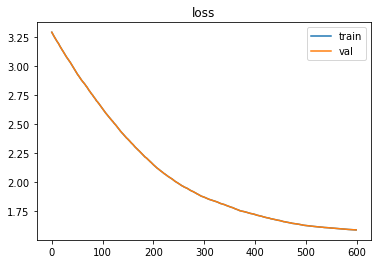

In [113]:
tr, te = losses
plt.title('loss')
plt.plot([e[0] for e in tr], label='train')
plt.plot([e[0] for e in tr], label='val')
plt.legend()
"""plt.title('loss')
plt.plot([e[0] for e in tr1], label='1')
plt.plot([e[0] for e in tr2], label='2')
plt.plot([e[0] for e in tr3], label='3')
plt.legend()"""

"plt.title('acc')\nplt.plot([e[1] for e in te1], label='1')\nplt.plot([e[1] for e in te2], label='2')\nplt.plot([e[1] for e in te3], label='3')\nplt.legend()"

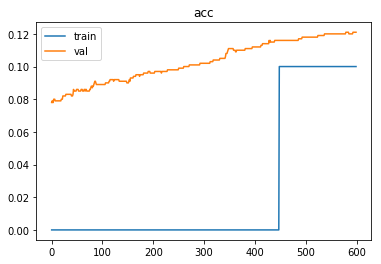

In [114]:
plt.title('acc')
plt.plot([e[1] for e in tr], label='train')
plt.plot([e[1] for e in te], label='val')
plt.legend()
"""plt.title('acc')
plt.plot([e[1] for e in te1], label='1')
plt.plot([e[1] for e in te2], label='2')
plt.plot([e[1] for e in te3], label='3')
plt.legend()"""

In [324]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test_fin, net)